<a href="https://colab.research.google.com/github/1247vardhini/Netflix/blob/main/ECommerce_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

##Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [4]:
#Import the data set
df = pd.read_csv('/content/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [5]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  335100
No of columns =  3


### Datatypes

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335100 entries, 0 to 335099
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  335100 non-null  object 
 1   prod_id  335099 non-null  object 
 2   rating   335099 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.7+ MB


### Missing value analysis

In [7]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,1
rating,1


### Summary

In [8]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,335099.000000
mean,3.995950
std,1.385577
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

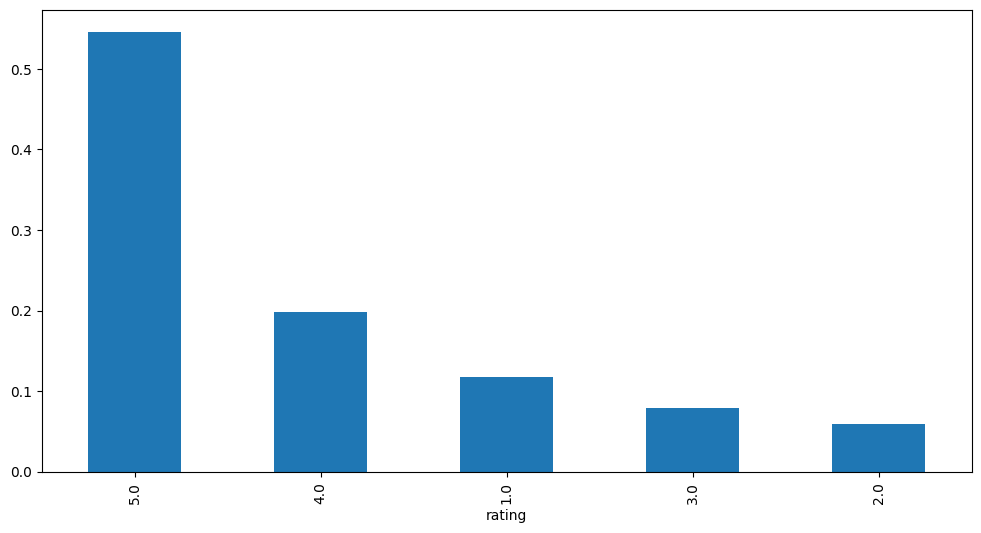

In [9]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [10]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  278824
Number of unique ITEMS in Raw data =  21173


### Users with most no of rating

In [11]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A231WM2Z2JL0U3,239
A5JLAU2ARJ0BO,195
A25HBO5V8S8SEA,123
AKT8TGIT6VVZ5,73
A2AEZQ3DGBBLPR,68
A6FIAB28IS79,63
A11D1KHM7DVOQK,59
AT2J7H5TRZM8Z,57
A1MJMYLRTZ76ZX,56


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [12]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [13]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 1147
Number of unique USERS in the final data =  13
Number of unique PRODUCTS in the final data =  1005


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [14]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (13, 1005)
given_num_of_ratings =  1147
possible_num_of_ratings =  13065
density: 8.78%


prod_id,1400532655,B000000O48,B000001OMN,B00000J05A,B00000J1E6,B00000J1G6,B00000J1TX,B00000J1UQ,B00000J1US,B00000J1UU,...,B0000BZZG1,B0000BZZG9,B0000BZZGB,B0000BZZGE,B0000C1ZHO,B0000C20XC,B0000C2W57,B0000C3GWV,B0000C3WBD,B0000C4DX5
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Rank Based Recommendation System

In [18]:
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')


In [17]:
print(df_final['rating'].dtype)


float64


In [19]:
df_final = df_final.dropna(subset=['rating'])


In [20]:
average_rating = df_final.groupby('prod_id')['rating'].mean()
count_rating = df_final.groupby('prod_id')['rating'].count()
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)
print(final_rating.head())


            avg_rating  rating_count
prod_id                             
B00000J4FS         5.0             1
B0000C4DX5         5.0             1
B0000C3WBD         5.0             1
B000000O48         5.0             1
B0000C3GWV         5.0             1


In [21]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommending top 5 products with 50 minimum interactions based on popularity

In [22]:
list(top_n_products(final_rating, 5, 50))

[]

## Recommending top 5 products with 100 minimum interactions based on popularity

In [23]:
list(top_n_products(final_rating, 5, 100))

[]

# Collaborative Filtering based Recommendation System

## User based collaborative filtering

In [24]:
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OMN,B00000J05A,B00000J1E6,B00000J1G6,B00000J1TX,B00000J1UQ,B00000J1US,B00000J1UU,...,B0000BZZG1,B0000BZZG9,B0000BZZGB,B0000BZZGE,B0000C1ZHO,B0000C20XC,B0000C2W57,B0000C3GWV,B0000C3WBD,B0000C4DX5
user_id,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [25]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OMN,B00000J05A,B00000J1E6,B00000J1G6,B00000J1TX,B00000J1UQ,B00000J1US,B00000J1UU,...,B0000BZZG1,B0000BZZG9,B0000BZZGB,B0000BZZGE,B0000C1ZHO,B0000C20XC,B0000C2W57,B0000C3GWV,B0000C3WBD,B0000C4DX5
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [26]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [27]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[12, 8, 10, 5, 7, 9, 4, 1, 2, 6]

In [28]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.11455245]]),
 array([[0.09342675]]),
 array([[0.06077579]]),
 array([[0.05684757]]),
 array([[0.05553816]]),
 array([[0.04222217]]),
 array([[0.04119319]]),
 array([[0.03583555]]),
 array([[0.02723227]]),
 array([[0.02151134]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [31]:
print(1521 in final_ratings_matrix.index)
print(final_ratings_matrix.index.dtype)
final_ratings_matrix.index = final_ratings_matrix.index.astype(int)
print(final_ratings_matrix.head())
if 1521 in final_ratings_matrix.index:
    similar = similar_users(1521, final_ratings_matrix)[0][0:10]
else:
    print("User 1521 not found in final_ratings_matrix.")


False
int64
prod_id     1400532655  B000000O48  B000001OMN  B00000J05A  B00000J1E6  \
user_index                                                               
0                  0.0         0.0         2.0         0.0         0.0   
1                  0.0         0.0         0.0         0.0         0.0   
2                  0.0         0.0         0.0         0.0         0.0   
3                  0.0         0.0         0.0         0.0         0.0   
4                  0.0         0.0         0.0         0.0         0.0   

prod_id     B00000J1G6  B00000J1TX  B00000J1UQ  B00000J1US  B00000J1UU  ...  \
user_index                                                              ...   
0                  1.0         0.0         0.0         0.0         0.0  ...   
1                  0.0         0.0         0.0         0.0         0.0  ...   
2                  0.0         0.0         0.0         0.0         0.0  ...   
3                  0.0         0.0         0.0         5.0         0.0  ..

In [33]:
user_id = 1521

# Check if user_id exists in the index
if user_id in final_ratings_matrix.index:
    similar = similar_users(user_id, final_ratings_matrix)[:10]  # Removed [0] to avoid IndexError
    print(similar)
else:
    print(f"User ID {user_id} not found in the dataset.")


User ID 1521 not found in the dataset.


In [37]:
user_id = 1521

# Ensure the index is of integer type
final_ratings_matrix.index = final_ratings_matrix.index.astype(int)

# Check if user_id exists in the index before accessing
if user_id in final_ratings_matrix.index:
    similarity_scores = similar_users(user_id, final_ratings_matrix)[1][0:10]
    print(similarity_scores)
else:
    print(f"User ID {user_id} not found in the dataset.")


User ID 1521 not found in the dataset.


### Function to recommend products

In [38]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [39]:
recommendations(3,5,final_ratings_matrix)

['B00005M011', 'B00005V619', 'B000066R6S', 'B00005KAMT', 'B00004YNWQ']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [45]:
user_id = 1521

# Ensure the index is of integer type
final_ratings_matrix.index = final_ratings_matrix.index.astype(int)

# Check if user_id exists in the index before accessing
if user_id in final_ratings_matrix.index:
    recommended_items = recommendations(user_id, 5, final_ratings_matrix)
    print(recommended_items)
else:
    print(f"User ID {user_id} not found in the dataset.")


User ID 1521 not found in the dataset.


# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [41]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [48]:
from scipy.sparse.linalg import svds
import numpy as np

# Check the shape of final_ratings_sparse
print("Matrix shape:", final_ratings_sparse.shape)

# Ensure k is valid (must be smaller than dimensions)
k = min(50, final_ratings_sparse.shape[0] - 1, final_ratings_sparse.shape[1] - 1)

# Check and replace NaN values
if np.isnan(final_ratings_sparse).any():
    print("NaN values found! Replacing with 0.")
    final_ratings_sparse = np.nan_to_num(final_ratings_sparse)

# Convert to sparse matrix (if needed)
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_sparse)

# Perform SVD
U, s, Vt = svds(final_ratings_sparse, k=k)

# Construct diagonal matrix for singular values
sigma = np.diag(s)

print("SVD completed successfully!")


Matrix shape: (13, 1005)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
U.shape

(1540, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 48190)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [49]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


In [54]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Ensure final_ratings_sparse is in sparse format
final_ratings_sparse = csr_matrix(final_ratings_sparse)

# Check matrix shape and adjust k
num_users, num_items = final_ratings_sparse.shape
print(f"Matrix dimensions: {num_users} users, {num_items} items")

k = min(50, num_users - 1, num_items - 1)

# Perform SVD
U, s, Vt = svds(final_ratings_sparse, k=k)
sigma = np.diag(s)

# Compute predicted ratings matrix
preds_matrix = np.dot(np.dot(U, sigma), Vt)

# Ensure user_id is within range
user_id = 121  # Example user ID
num_recommendations = 5

# Check if user_id exists in the matrix
if user_id >= num_users or user_id < 0:
    print(f"Error: User ID {user_id} is out of range (0 to {num_users - 1})")
else:
    recommendations = recommend_items(user_id, final_ratings_sparse, preds_matrix, num_recommendations)
    print(recommendations)


Matrix dimensions: 13 users, 1005 items
Error: User ID 121 is out of range (0 to 12)


### Recommending top 5 products to user id 121

### Recommending top 10 products to user id 100

In [56]:
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Ensure final_ratings_sparse is in sparse format
final_ratings_sparse = csr_matrix(final_ratings_sparse)

# Get number of users and items
num_users, num_items = final_ratings_sparse.shape
print(f"Matrix dimensions: {num_users} users, {num_items} items")

# Check available indices
print(f"Valid user indices: 0 to {num_users - 1}")

# Ensure user_id is valid
user_id = 100  # Example user ID
num_recommendations = 10

if user_id >= num_users or user_id < 0:
    print(f"Error: User ID {user_id} is out of range (valid range: 0 to {num_users - 1})")
else:
    # Perform SVD
    k = min(50, num_users - 1, num_items - 1)
    U, s, Vt = svds(final_ratings_sparse, k=k)
    sigma = np.diag(s)

    # Compute predicted ratings matrix
    preds_matrix = np.dot(np.dot(U, sigma), Vt)

    # Generate recommendations
    recommendations = recommend_items(user_id, final_ratings_sparse, preds_matrix, num_recommendations)
    print(recommendations)


Matrix dimensions: 13 users, 1005 items
Valid user indices: 0 to 12
Error: User ID 100 is out of range (valid range: 0 to 12)


## Evaluating the model

In [57]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,1400532655,B000000O48,B000001OMN,B00000J05A,B00000J1E6,B00000J1G6,B00000J1TX,B00000J1UQ,B00000J1US,B00000J1UU,...,B0000BZZG1,B0000BZZG9,B0000BZZGB,B0000BZZGE,B0000C1ZHO,B0000C20XC,B0000C2W57,B0000C3GWV,B0000C3WBD,B0000C4DX5
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
1400532655,0.076923
B000000O48,0.384615
B000001OMN,0.153846
B00000J05A,0.230769
B00000J1E6,0.076923


In [60]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

# Ensure final_ratings_sparse is in the correct format
final_ratings_sparse = csr_matrix(final_ratings_sparse)

# Get number of users and items
num_users, num_items = final_ratings_sparse.shape

# Perform SVD
k = min(50, num_users - 1, num_items - 1)
U, s, Vt = svds(final_ratings_sparse, k=k)
sigma = np.diag(s)

# Compute predicted ratings matrix
preds_matrix = np.dot(np.dot(U, sigma), Vt)

# Convert to DataFrame
preds_df = pd.DataFrame(preds_matrix, index=range(num_users), columns=range(num_items))

# Display the first few rows
print(preds_df.head())


           0         1         2         3         4         5     \
0  4.959127e-03  0.145065  0.002795  0.067145  0.029013  0.001398   
1 -7.251489e-06 -0.000212  0.002920 -0.000098 -0.000042  0.001460   
2  2.656994e-06  0.000078 -0.001070  0.000036  0.000016 -0.000535   
3  8.825958e-06  0.000258 -0.003555  0.000120  0.000052 -0.001777   
4  9.166572e-07  0.000027 -0.000369  0.000012  0.000005 -0.000185   

           6         7         8             9     ...          995   \
0 -1.016637e-03  0.111908 -0.008886 -2.661874e-03  ... -8.133095e-04   
1  1.486579e-06 -0.000164  0.000013  3.892329e-06  ...  1.189263e-06   
2 -5.446922e-07  0.000060 -0.000005 -1.426175e-06  ... -4.357538e-07   
3 -1.809350e-06  0.000199  4.999984 -4.737445e-06  ... -1.447480e-06   
4 -1.879177e-07  0.000021 -0.000002 -4.920274e-07  ... -1.503341e-07   

           996           997           998           999           1000  \
0 -1.016637e-03 -1.016637e-03 -1.016637e-03 -5.331758e-03 -2.661874e-03   
1 

In [61]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
0,0.077286
1,0.395236
2,0.007627
3,0.235685
4,0.079047


In [62]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()


,Avg_actual_ratings,Avg_predicted_ratings
1400532655,0.076923,NaN
B000000O48,0.384615,NaN
B000001OMN,0.153846,NaN
B00000J05A,0.230769,NaN
B00000J1E6,0.076923,NaN


In [68]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np

# Combine actual and predicted ratings
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

# Rename columns
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

# Check for NaN values
print("Checking for NaN values:\n", rmse_df.isna().sum())

# Drop or fill NaN values
rmse_df_cleaned = rmse_df.dropna()  # Remove rows with NaN

# Compute RMSE
mse = mean_squared_error(rmse_df_cleaned['Avg_actual_ratings'], rmse_df_cleaned['Avg_predicted_ratings'])
rmse = np.sqrt(mse)

print(f'RMSE SVD Model = {rmse:.4f} \n')


Checking for NaN values:
 Avg_actual_ratings       1005
Avg_predicted_ratings    1005
dtype: int64


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.